## Convolutional networks for track finding on 1D detector planes

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred

from matplotlib import pyplot as plt
%matplotlib notebook

Using Theano backend.
Using gpu device 7: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Data generation

In [26]:
# Config parameters
det_width = 48
det_depth = 48
det_shape = (det_depth, det_width)
seed_size = 5
num_events = 102400

In [27]:
# Signal tracks
tracks = generate_straight_tracks(num_events, det_shape)
# Background tracks
bkgs = generate_track_bkg(num_events, det_shape,
                          tracks_per_event=5, skip_layers=seed_size)
# Noise
noise = generate_uniform_noise(num_events, det_shape,
                               prob=0.2, skip_layers=seed_size)

## Model definitions

In [53]:
def build_conv_model(shape, num_layers=10, num_filters=8):
    """Build the simple convolutional model"""
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutional layers
    for _ in range(num_layers):
        hidden = layers.Conv2D(num_filters, 3, 3, border_mode='same', activation='relu')(hidden)
    conv_args = dict(border_mode='same', activation='relu')
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Training on single tracks

In [23]:
#events = tracks + bkgs
#events[events>1] = 1
train_input = tracks
train_target = tracks

In [24]:
model1 = build_conv_model(det_shape)
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 50, 50)        0                                            
____________________________________________________________________________________________________
reshape_6 (Reshape)              (None, 1, 50, 50)     0           input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_56 (Convolution2D) (None, 8, 50, 50)     80          reshape_6[0][0]                  
____________________________________________________________________________________________________
convolution2d_57 (Convolution2D) (None, 8, 50, 50)     584         convolution2d_56[0][0]           
___________________________________________________________________________________________

In [25]:
model1.fit(train_input, train_target, batch_size=250, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 56s - loss: 0.1861 - acc: 0.9630    
Epoch 2/10
100000/100000 [==============================] - 57s - loss: 0.0266 - acc: 0.9983    
Epoch 3/10
100000/100000 [==============================] - 57s - loss: 0.0263 - acc: 0.9984    
Epoch 4/10
100000/100000 [==============================] - 64s - loss: 0.0263 - acc: 0.9984    
Epoch 5/10
100000/100000 [==============================] - 65s - loss: 0.2912 - acc: 0.9756    
Epoch 6/10
100000/100000 [==============================] - 65s - loss: 0.0029 - acc: 0.9991    
Epoch 7/10
100000/100000 [==============================] - 60s - loss: 7.9498e-04 - acc: 0.9998    
Epoch 8/10
100000/100000 [==============================] - 56s - loss: 3.1914e-04 - acc: 1.0000    
Epoch 9/10
100000/100000 [==============================] - 57s - loss: 1.5192e-04 - acc: 1.0000    
Epoch 10/10
100000/100000 [==============================] - 56s - loss: 7.8861e-05 - acc: 1.0000    


In [26]:
train_pred = model1.predict(train_input)

<IPython.core.display.Javascript object>


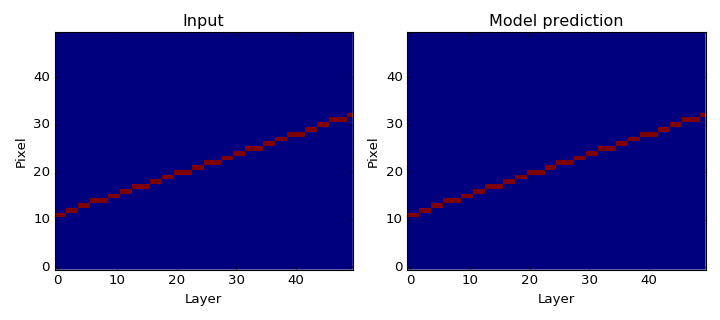

In [28]:
i = 0
draw_2d_input_and_pred(train_input[i], train_pred[i])

## Training on multi-track events

In [9]:
train2_input = events
train2_target = tracks

In [30]:
model2 = build_conv_model(det_shape)

In [31]:
model2.fit(train2_input, train2_target, batch_size=250, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 59s - loss: 1.5869 - acc: 0.3534    
Epoch 2/10
100000/100000 [==============================] - 59s - loss: 1.3144 - acc: 0.4068    
Epoch 3/10
100000/100000 [==============================] - 60s - loss: 1.2712 - acc: 0.4202    
Epoch 4/10
100000/100000 [==============================] - 59s - loss: 1.2494 - acc: 0.4284    
Epoch 5/10
100000/100000 [==============================] - 59s - loss: 1.2404 - acc: 0.4324    
Epoch 6/10
100000/100000 [==============================] - 61s - loss: 1.2306 - acc: 0.4368    
Epoch 7/10
100000/100000 [==============================] - 66s - loss: 1.3792 - acc: 0.4124    
Epoch 8/10
100000/100000 [==============================] - 65s - loss: 1.3519 - acc: 0.4020    
Epoch 9/10
100000/100000 [==============================] - 65s - loss: 1.2943 - acc: 0.4162    
Epoch 10/10
100000/100000 [==============================] - 61s - loss: 1.2733 - acc: 0.4224    


In [32]:
train2_pred = model2.predict(train2_input)

<IPython.core.display.Javascript object>


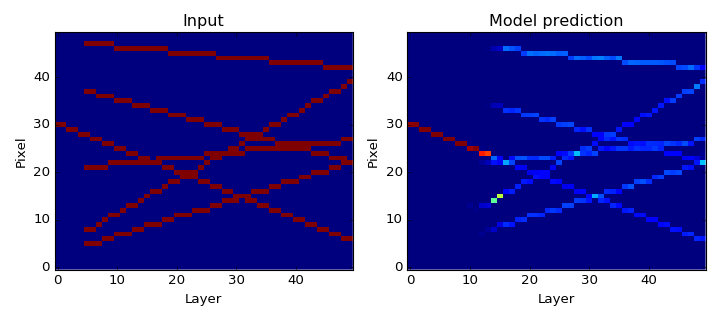

In [35]:
i = 12
draw_2d_input_and_pred(train2_input[i], train2_pred[i])

<IPython.core.display.Javascript object>


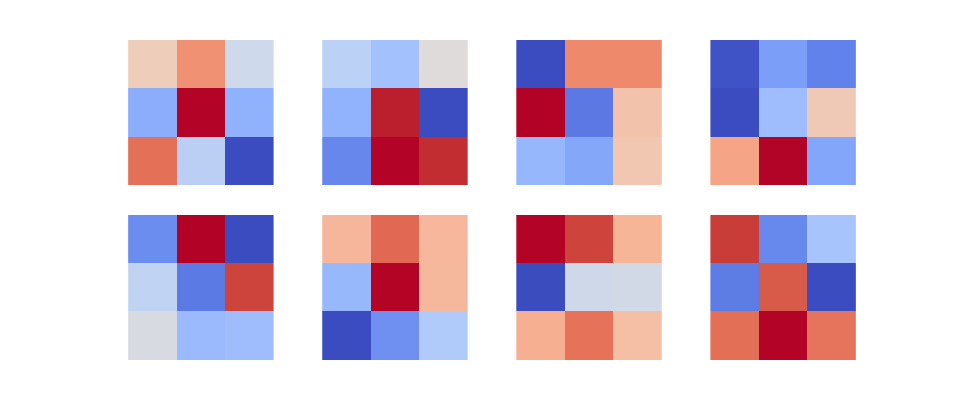

In [46]:
w = np.squeeze(model2.get_weights()[0])

# Visualize the first-layer filters
plt.figure(figsize=(12,5))
for i in range(2):
    for j in range(4):
        plt.subplot(2, 4, i*4 + j + 1)
        plt.imshow(w[i*4+j], interpolation='none', cmap='coolwarm')
        plt.axis('off')

In [ ]:
# Dry a deeper model
train3_input = train2_input
train3_target = train2_target
model3 = build_conv_model(det_shape, num_layers=20)
model3.fit(train3_input, train3_target, batch_size=250, nb_epoch=10)
train3_pred = model3.predict(train3_input)

Epoch 1/10
100000/100000 [==============================] - 102s - loss: 1.7932 - acc: 0.3356   
Epoch 2/10
100000/100000 [==============================] - 103s - loss: 1.4731 - acc: 0.4254   
Epoch 3/10
100000/100000 [==============================] - 103s - loss: 1.3765 - acc: 0.4329   
Epoch 4/10
100000/100000 [==============================] - 103s - loss: 1.2289 - acc: 0.4734   
Epoch 5/10
100000/100000 [==============================] - 104s - loss: 1.1592 - acc: 0.4955   
Epoch 6/10
100000/100000 [==============================] - 115s - loss: 1.1081 - acc: 0.5120   
Epoch 7/10
100000/100000 [==============================] - 110s - loss: 1.0716 - acc: 0.5249   
Epoch 8/10
100000/100000 [==============================] - 103s - loss: 1.0508 - acc: 0.5324   
Epoch 9/10
100000/100000 [==============================] - 102s - loss: 1.0300 - acc: 0.5402   
Epoch 10/10
  1750/100000 [..............................] - ETA: 97s - loss: 1.0174 - acc: 0.5454

<IPython.core.display.Javascript object>


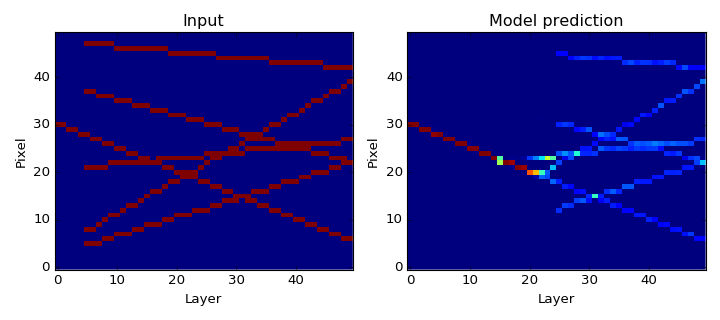

In [49]:
i = 12
draw_2d_input_and_pred(train3_input[i], train3_pred[i])

<IPython.core.display.Javascript object>


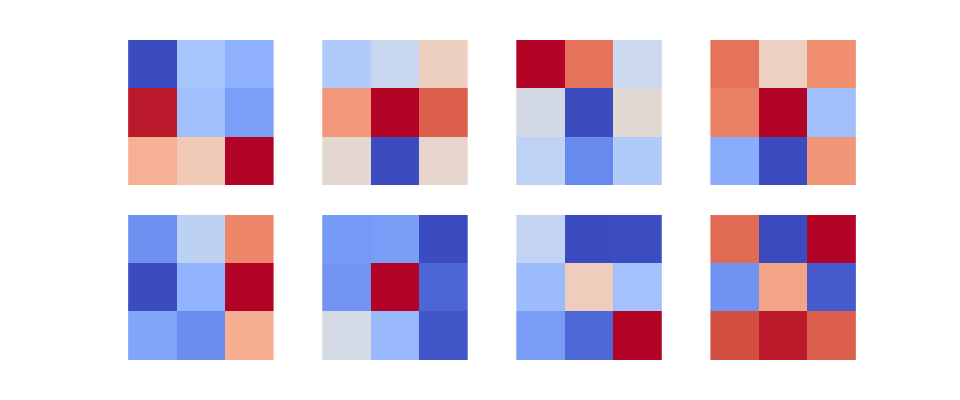

In [50]:
w = np.squeeze(model3.get_weights()[0])

# Visualize the first-layer filters
plt.figure(figsize=(12,5))
for i in range(2):
    for j in range(4):
        plt.subplot(2, 4, i*4 + j + 1)
        plt.imshow(w[i*4+j], interpolation='none', cmap='coolwarm')
        plt.axis('off')

## Train a convolutional autoencoder

In [28]:
def build_convae_model(shape):
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutions and down-sampling
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    # Convolutions and up-sampling
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [29]:
events = tracks + bkgs
events[events>1] = 1

In [30]:
train4_input = events
train4_target = tracks
model4 = build_convae_model(det_shape)
model4.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_8 (Reshape)              (None, 1, 48, 48)     0           input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_33 (Convolution2D) (None, 8, 48, 48)     80          reshape_8[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_15 (MaxPooling2D)   (None, 8, 24, 24)     0           convolution2d_33[0][0]           
___________________________________________________________________________________________

In [31]:
model4.fit(train4_input, train4_target, batch_size=128, nb_epoch=20)
train4_pred = model4.predict(train4_input)

Epoch 1/20
102400/102400 [==============================] - 43s - loss: 2.3135 - acc: 0.2329    
Epoch 2/20
102400/102400 [==============================] - 43s - loss: 1.4692 - acc: 0.4239    
Epoch 3/20
102400/102400 [==============================] - 43s - loss: 1.2714 - acc: 0.4926    
Epoch 4/20
102400/102400 [==============================] - 43s - loss: 1.1498 - acc: 0.5369    
Epoch 5/20
102400/102400 [==============================] - 43s - loss: 1.0688 - acc: 0.5665    
Epoch 6/20
102400/102400 [==============================] - 43s - loss: 1.0043 - acc: 0.5910    
Epoch 7/20
102400/102400 [==============================] - 43s - loss: 0.9559 - acc: 0.6088    
Epoch 8/20
102400/102400 [==============================] - 43s - loss: 0.9125 - acc: 0.6255    
Epoch 9/20
102400/102400 [==============================] - 43s - loss: 0.8834 - acc: 0.6370    
Epoch 10/20
102400/102400 [==============================] - 43s - loss: 0.8518 - acc: 0.6497    
Epoch 11/20
102400/102400 [==

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


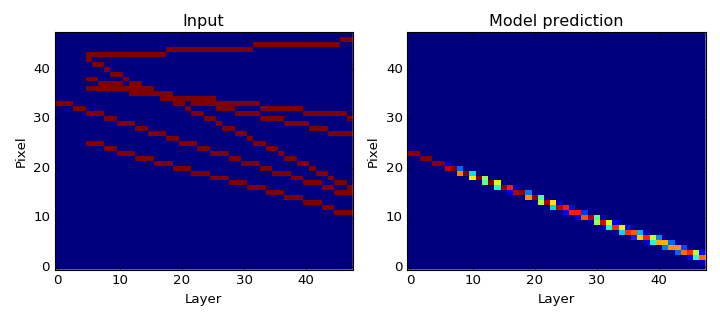

In [32]:
i = 12
draw_2d_input_and_pred(train4_input[i], train4_pred[i])

<IPython.core.display.Javascript object>


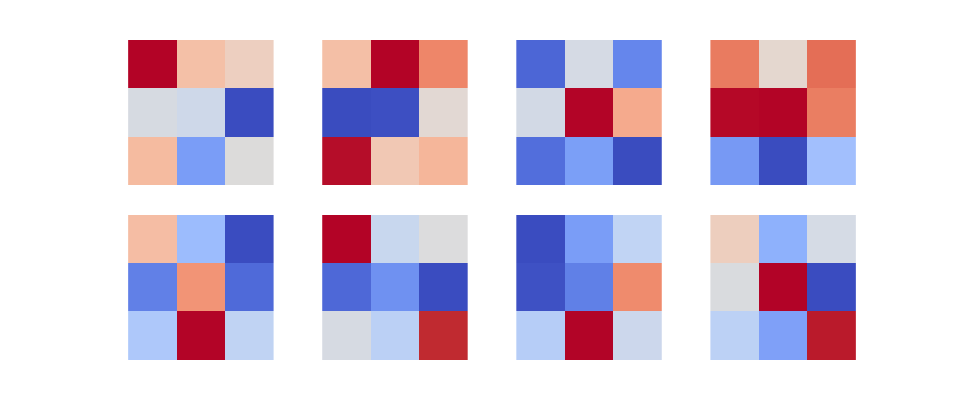

In [33]:
w = np.squeeze(model4.get_weights()[0])

# Visualize the first-layer filters
plt.figure(figsize=(12,5))
for i in range(2):
    for j in range(4):
        plt.subplot(2, 4, i*4 + j + 1)
        plt.imshow(w[i*4+j], interpolation='none', cmap='coolwarm')
        plt.axis('off')